<a href="https://colab.research.google.com/github/kkrusere/youTube-comments-Analyzer/blob/main/LLM_fine-tuned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import os
import json
#mounting google drive
drive.mount('/content/drive')

########################################

#changing the working directory
os.chdir("/content/drive/MyDrive/EV NLP Data")

!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/EV NLP Data


In [2]:
# !pip install -q kaggle
# !mkdir -p ~/.kaggle
# !mv kaggle.json ~/.kaggle/
# !kaggle datasets download -d widhiwinata/twitter-and-reddit-sentiment-analysis
# !unzip twitter-and-reddit-sentiment-analysis.zip
# !rm twitter-and-reddit-sentiment-analysis.zip

In [3]:
!pip install nltk

We are going to do a semi supervised lable propergation

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import string
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
sentimentdata = pd.read_csv("sentimentdataset.csv")
sentimentdata.head()

,Unnamed: 0.1,Unnamed: 0,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
0,0,0,Enjoying a beautiful day at the park! ...,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12
1,1,1,Traffic was terrible this morning. ...,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8
2,2,2,Just finished an amazing workout! 💪 ...,Positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,1,15,15
3,3,3,Excited about the upcoming weekend getaway! ...,Positive,2023-01-15 18:20:00,AdventureX,Facebook,#Travel #Adventure,8.0,15.0,UK,2023,1,15,18
4,4,4,Trying out a new recipe for dinner tonight. ...,Neutral,2023-01-15 19:55:00,ChefCook,Instagram,#Cooking #Food,12.0,25.0,Australia,2023,1,15,19


In [6]:
sentimentdata = sentimentdata[['Text', 'Sentiment']]
sentimentdata.head()

,Text,Sentiment
0,Enjoying a beautiful day at the park! ...,Positive
1,Traffic was terrible this morning. ...,Negative
2,Just finished an amazing workout! 💪 ...,Positive
3,Excited about the upcoming weekend getaway! ...,Positive
4,Trying out a new recipe for dinner tonight. ...,Neutral


In [7]:
# Cleaning-up
sentimentdata['Sentiment'] = sentimentdata['Sentiment'].str.strip()
sentimentdata['Sentiment'] = sentimentdata['Sentiment'].str.lower()


In [8]:
sentimentdata.shape

(732, 2)

In [9]:
sentimentdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       732 non-null    object
 1   Sentiment  732 non-null    object
dtypes: object(2)
memory usage: 11.6+ KB


In [10]:
sentimentdata.head()

,Text,Sentiment
0,Enjoying a beautiful day at the park! ...,positive
1,Traffic was terrible this morning. ...,negative
2,Just finished an amazing workout! 💪 ...,positive
3,Excited about the upcoming weekend getaway! ...,positive
4,Trying out a new recipe for dinner tonight. ...,neutral


In [11]:
sentimentdata['Sentiment'].value_counts()

Sentiment
positive          45
joy               44
excitement        37
contentment       19
neutral           18
                  ..
lostlove           1
emotionalstorm     1
suffering          1
bittersweet        1
intrigue           1
Name: count, Length: 191, dtype: int64

In [12]:
def classify_sentiment(sentiment):
    positive_words = ['positive', 'happiness', 'joy', 'love', 'amusement', 'enjoyment', 'admiration', 'affection', 'awe', 'elation', 'euphoria', 'contentment', 'serenity', 'gratitude', 'hope', 'empowerment', 'compassion', 'tenderness', 'arousal', 'enthusiasm', 'fulfillment', 'reverence', 'playful', 'free-spirited', 'inspired', 'confident', 'zest', 'hopeful', 'proud', 'grateful', 'empathetic', 'compassionate', 'inspiration', 'motivation', 'satisfaction', 'blessed', 'optimism', 'enchantment', 'intrigue', 'playfuljoy', 'mindfulness', 'dreamchaser', 'whimsy', 'harmony', 'creativity', 'radiance', 'wonder', 'rejuvenation', 'adventure', 'awe', 'melodic', 'festivejoy', 'innerjourney', 'freedom', 'dazzle', 'harmony', 'artisticburst', 'radiance', 'wonder', 'inspiration', 'culinaryodyssey', 'curiosity', 'resilience', 'immersion', 'nostalgia', 'spark', 'gratitude', 'marvel', 'serenity', 'joy', 'happiness', 'enthusiasm', 'gratitude', 'positivity', 'kindness', 'friendship', 'love', 'success', 'thrill', 'reflection', 'enchantment', 'exploration', 'awe', 'amazement', 'romance', 'captivation', 'wonder', 'tranquility', 'grandeur', 'emotion', 'energy', 'celebration', 'charm', 'ecstasy', 'hope', 'creativity', 'colorful', 'pride', 'hypnotic', 'connection', 'iconic', 'euphoria', 'journey', 'engagement', 'touched', 'suspense', 'satisfaction', 'admiration', 'triumph', 'heartwarming', 'solace', 'breakthrough', 'joy in baking', 'imagination', 'vibrancy', 'mesmerizing', 'culinary adventure', 'winter magic', 'thrilling journey', 'nature\'s beauty', 'celestial wonder', 'creative inspiration', 'runway creativity', 'ocean\'s freedom', 'whispers of the past', 'positive', 'mischievous', 'happy']

    negative_words = ['negative', 'anger', 'fear', 'sadness', 'disgust', 'disappointed', 'despair', 'loneliness', 'jealousy', 'resentment', 'frustration', 'boredom', 'anxiety', 'intimidation', 'helplessness', 'envy', 'regret', 'bitter', 'confusion', 'overwhelmed', 'jealous', 'devastated', 'envious', 'dismissive', 'shame', 'elation', 'despair', 'grief', 'loneliness', 'frustration', 'anxiety', 'intimidation', 'helplessness', 'jealousy', 'curiosity', 'indifference', 'confusion', 'numbness', 'melancholy', 'nostalgia', 'ambivalence', 'acceptance', 'determination', 'numbness', 'bitterness', 'fearful', 'apprehensive', 'overwhelmed', 'jealous', 'devastated', 'frustrated', 'envious', 'dismissive', 'betrayal', 'suffering', 'emotionalstorm', 'isolation', 'disappointment', 'lostlove', 'melancholy', 'exhaustion', 'sorrow', 'darkness', 'desperation', 'ruins', 'desolation', 'regret', 'grief', 'heartbreak', 'betrayal', 'resilience', 'sorrow', 'loss', 'heartache', 'solitude', 'sad', 'hate', 'bad', 'disgust', 'embarrassed', 'mischievous']

    if sentiment in positive_words:
        return 'Positive'
    elif sentiment in negative_words:
        return 'Negative'
    else:
        return 'Neutral'



In [13]:
# We are using the `classify_sentiment` function to categorize the comment into 3 Positive, Negative and Neutral
sentimentdata['Sentiment'] = sentimentdata['Sentiment'].apply(classify_sentiment)

In [14]:
sentimentdata.head()

,Text,Sentiment
0,Enjoying a beautiful day at the park! ...,Positive
1,Traffic was terrible this morning. ...,Negative
2,Just finished an amazing workout! 💪 ...,Positive
3,Excited about the upcoming weekend getaway! ...,Positive
4,Trying out a new recipe for dinner tonight. ...,Neutral


In [15]:
sentimentdata['Sentiment'].value_counts()

Sentiment
Positive    415
Negative    218
Neutral      99
Name: count, dtype: int64

In [16]:
# Function to save comments data to a JSON file
def save_comments_to_json(comments, filename = 'youtube_comments.json'):
    with open(filename, 'w') as json_file:
        json.dump(comments, json_file, indent=4)

def load_comments_from_json(filename = 'youtube_comments.json'):
    with open(filename, 'r') as json_file:
        comments = json.load(json_file)
    return comments

In [17]:
comments_data = load_comments_from_json()
# Load the JSON data into a Pandas DataFrame
comments_data_df = pd.DataFrame(comments_data)

# Drop null values in the `comment_text ` column
comments_data_df = comments_data_df.dropna(subset=['comment_text'])
# Drop duplicates if there are any in the `comment_text ` column
comments_data_df = comments_data_df.drop_duplicates(subset='comment_text')


# Lowercase the text
comments_data_df['comment_text_cleaned'] = comments_data_df['comment_text'].str.lower()
# Remove punctuation
comments_data_df['comment_text_cleaned'] = comments_data_df['comment_text_cleaned'].apply(lambda x: ''.join([char for char in x if char not in string.punctuation]))

# Remove stop words
stop_words = stopwords.words('english')
comments_data_df['comment_text_cleaned'] = comments_data_df['comment_text_cleaned'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))


#reset dataframe index
comments_data_df.reset_index(inplace=True, drop=True)

comments_data_df.head()

,comment_text,like_count,reply_count,comment_text_cleaned
0,A major obstacle to EV adoption that is always...,6K,507 replies,major obstacle ev adoption always overlooked i...
1,"Prices are too high, and dealerships keep addi...",3.9K,216 replies,prices high dealerships keep adding dealership...
2,The government isn’t fast enough to patch poth...,89,6 replies,government isn’t fast enough patch potholes ro...
3,We have the coldest winters in many years here...,34,1 reply,coldest winters many years scandinavia places ...
4,"Im not fond of Tesla, but I do like the fact t...",6K,411 replies,im fond tesla like fact theyve steadily slashi...


## **Modeling**

In [18]:
# Create a copy of the data
df = sentimentdata.copy()

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [19]:
def preprocess_text(text):
    # Remove extra spaces and punctuation
    text = text.strip()
    text = ''.join([c for c in text if c.isalnum() or c.isspace()])
    # Tokenization
    tokens = word_tokenize(text.lower())
    # Removing stop words and lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [20]:
df['Text'] = df['Text'].apply(preprocess_text)

# Feature extraction
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['Text'])
y = df['Sentiment']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
def plot_confusion_matrix(y_true, y_pred):
  """
  This function creates and plots the confusion matrix for a given set of true and predicted labels.

  Args:
      y_true: A list containing the true labels.
      y_pred: A list containing the predicted labels.
  """
  # Generate the confusion matrix
  cm = confusion_matrix(y_true, y_pred)

  # Create a subplot for the confusion matrix
  ax = plt.subplot()

  # Plot the confusion matrix using seaborn
  sns.heatmap(cm, annot=True, ax=ax)  # Annotate cells with values

  # Set labels and title
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels')
  ax.set_title('Confusion Matrix')

  # Set tick labels for x and y axes
  ax.xaxis.set_ticklabels(['Negative', 'Neutral', 'Positive'])
  ax.yaxis.set_ticklabels(['Negative', 'Neutral', 'Positive'])

  # Display the plot
  plt.show()


### **Naive Bayes classifier**

Accuracy: 0.8027210884353742
Classification Report:
              precision    recall  f1-score   support

    Negative       0.89      0.84      0.86        49
     Neutral       0.41      0.47      0.44        19
    Positive       0.86      0.86      0.86        79

    accuracy                           0.80       147
   macro avg       0.72      0.72      0.72       147
weighted avg       0.81      0.80      0.81       147



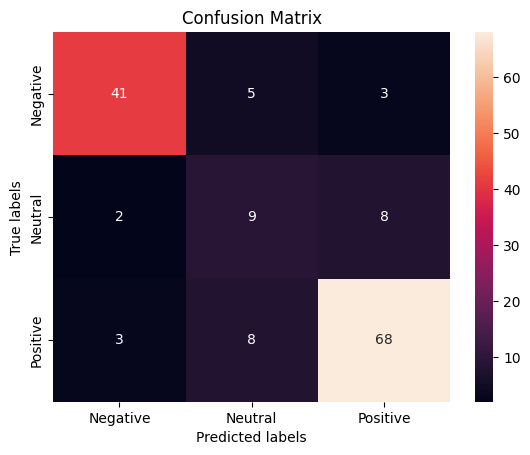

In [22]:
from sklearn.naive_bayes import MultinomialNB
# Training the Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

# Predicting on the test set
y_pred_nb = nb_classifier.predict(X_test)

# Model evaluation
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print("Accuracy:", accuracy_nb)
print("Classification Report:")
print(classification_report(y_test, y_pred_nb))

plot_confusion_matrix(y_test, y_pred_nb)


### **Logistic Regression**


Accuracy: 0.7959183673469388
Classification Report:
              precision    recall  f1-score   support

    Negative       0.95      0.76      0.84        49
     Neutral       0.80      0.21      0.33        19
    Positive       0.74      0.96      0.84        79

    accuracy                           0.80       147
   macro avg       0.83      0.64      0.67       147
weighted avg       0.82      0.80      0.77       147



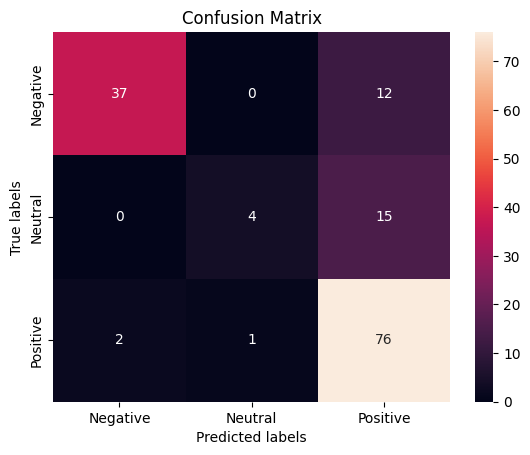

In [23]:
from sklearn.linear_model import LogisticRegression

# Training the Logistic Regression classifier
lr_classifier = LogisticRegression()
lr_classifier.fit(X_train, y_train)

# Predicting on the test set
y_pred_lr = lr_classifier.predict(X_test)

# Model evaluation
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print("Accuracy:", accuracy_lr)
print("Classification Report:")
print(classification_report(y_test, y_pred_lr))

plot_confusion_matrix(y_test, y_pred_lr)

### **Support Vector Machine**

Accuracy: 0.6666666666666666
Classification Report:
              precision    recall  f1-score   support

    Negative       0.95      0.41      0.57        49
     Neutral       0.00      0.00      0.00        19
    Positive       0.62      0.99      0.76        79

    accuracy                           0.67       147
   macro avg       0.52      0.47      0.44       147
weighted avg       0.65      0.67      0.60       147



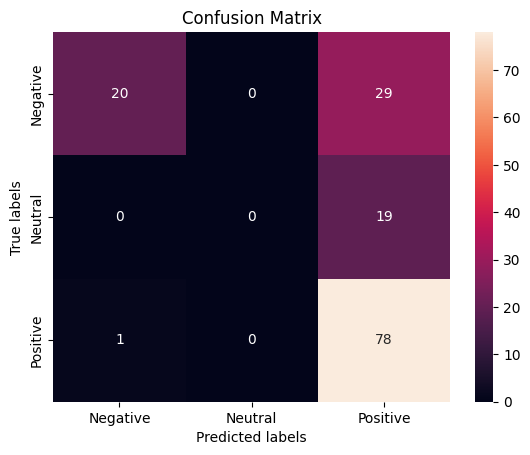

In [24]:
from sklearn.svm import SVC
# Training the Support Vector Machine classifier
svm_classifier = SVC()
svm_classifier.fit(X_train, y_train)

# Predicting on the test set
y_pred_svm = svm_classifier.predict(X_test)

# Model evaluation
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("Accuracy:", accuracy_svm)
print("Classification Report:")
print(classification_report(y_test, y_pred_svm))

plot_confusion_matrix(y_test, y_pred_svm)

### **Random Forest Classifier**

Accuracy: 0.7210884353741497
Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      0.51      0.68        49
     Neutral       1.00      0.11      0.19        19
    Positive       0.66      1.00      0.79        79

    accuracy                           0.72       147
   macro avg       0.89      0.54      0.55       147
weighted avg       0.82      0.72      0.68       147



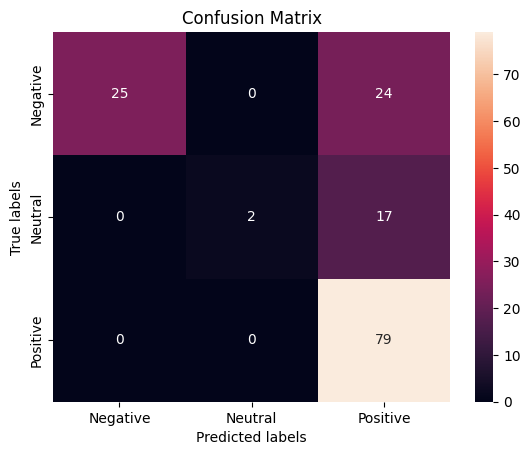

In [25]:
from sklearn.ensemble import RandomForestClassifier
# Training the Random Forest classifier
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)

# Predicting on the test set
y_pred_rf = rf_classifier.predict(X_test)

# Model evaluation
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Accuracy:", accuracy_rf)
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))

plot_confusion_matrix(y_test, y_pred_rf)

### **Recurrent Neural Networks (RNNs)**

In [26]:
# Import the necessary libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

from sklearn.preprocessing import LabelEncoder


Epoch 1/10
19/19 [==============================] - 3s 104ms/step - loss: 797.9110 - accuracy: 0.5538 - val_loss: 1.0103 - val_accuracy: 0.5374
Epoch 2/10
19/19 [==============================] - 2s 93ms/step - loss: 1.0114 - accuracy: 0.5744 - val_loss: 1.0192 - val_accuracy: 0.5374
Epoch 3/10
19/19 [==============================] - 2s 92ms/step - loss: 0.9617 - accuracy: 0.5744 - val_loss: 0.9667 - val_accuracy: 0.5374
Epoch 4/10
19/19 [==============================] - 2s 97ms/step - loss: 0.9018 - accuracy: 0.5744 - val_loss: 0.9190 - val_accuracy: 0.5374
Epoch 5/10
19/19 [==============================] - 2s 99ms/step - loss: 0.8568 - accuracy: 0.5932 - val_loss: 0.9003 - val_accuracy: 0.5442
Epoch 6/10
19/19 [==============================] - 2s 96ms/step - loss: 0.7848 - accuracy: 0.7350 - val_loss: 0.8842 - val_accuracy: 0.6735
Epoch 7/10
19/19 [==============================] - 2s 94ms/step - loss: 0.6516 - accuracy: 0.8530 - val_loss: 29069.9180 - val_accuracy: 0.3333
Epoch 

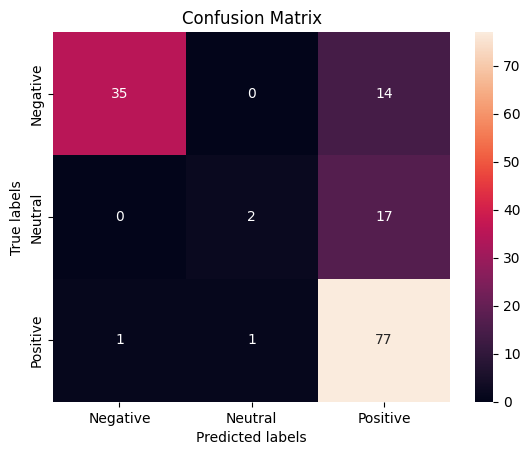

In [27]:
df['Text'] = df['Text'].apply(preprocess_text)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['Text'], df['Sentiment'], test_size=0.2, random_state=42)

# Create the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Convert text data to sequences
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

# Pad the sequences
max_len = 100  # Set the maximum sequence length
X_train_padded = pad_sequences(train_sequences, maxlen=max_len)
X_test_padded = pad_sequences(test_sequences, maxlen=max_len)

# Encode the target labels
label_encoder = LabelEncoder()
label_encoder.fit(sentimentdata['Sentiment'])
y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Define the RNN model
rnn_model = Sequential()
rnn_model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=128, input_length=max_len))
rnn_model.add(LSTM(128, activation='relu'))
rnn_model.add(Dense(3, activation='softmax'))  # Three neurons for three classes, softmax activation
rnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  # Use sparse_categorical_crossentropy for multi-class classification

# Train the model
rnn_model.fit(X_train_padded, y_train_encoded, epochs=10, batch_size=32, validation_data=(X_test_padded, y_test_encoded))

# Evaluate the model
loss, accuracy = rnn_model.evaluate(X_test_padded, y_test_encoded)

y_pred_rnn = rnn_model.predict(X_test_padded)
y_pred_rnn = np.argmax(y_pred_rnn, axis=1)

accuracy_rnn = accuracy_score(y_test_encoded, y_pred_rnn)


print(f"\n\nAccuracy_1: {accuracy}  vs Accuracy_2: {accuracy_rnn}")

print("Classification Report:")
print(classification_report(y_test_encoded, y_pred_rnn))

plot_confusion_matrix(y_test_encoded, y_pred_rnn)

### **Comparison of Models**

In [28]:
# Comparing the accuracy of different models
models = ['Naive Bayes', 'Logistic Regression', 'SVM', 'Random Forest', 'RNN']
accuracies = [round(accuracy_nb, 3), round(accuracy_lr, 3), round(accuracy_svm, 3), round(accuracy_rf, 3), round(accuracy_rnn, 3)]

for model, accuracy in zip(models, accuracies):
    print(f"{model}: {accuracy}")

Naive Bayes: 0.803
Logistic Regression: 0.796
SVM: 0.667
Random Forest: 0.721
RNN: 0.776


In [29]:
# Preprocess the comments data
comments_data_df['comment_text_cleaned'] = comments_data_df['comment_text_cleaned'].apply(preprocess_text)

# Feature extraction
X = vectorizer.transform(comments_data_df['comment_text_cleaned'])

comments_data_df['nb_predictions'] = nb_classifier.predict(X)
comments_data_df['lr_predictions'] = lr_classifier.predict(X)
comments_data_df['svm_predictions'] = svm_classifier.predict(X)
comments_data_df['rf_predictions'] = rf_classifier.predict(X)


comments_data_df.head()

,comment_text,like_count,reply_count,comment_text_cleaned,nb_predictions,lr_predictions,svm_predictions,rf_predictions
0,A major obstacle to EV adoption that is always...,6K,507 replies,major obstacle ev adoption always overlooked i...,Negative,Positive,Positive,Positive
1,"Prices are too high, and dealerships keep addi...",3.9K,216 replies,price high dealership keep adding dealership f...,Positive,Positive,Positive,Positive
2,The government isn’t fast enough to patch poth...,89,6 replies,government isnt fast enough patch pothole road...,Positive,Positive,Positive,Positive
3,We have the coldest winters in many years here...,34,1 reply,coldest winter many year scandinavia place nev...,Positive,Positive,Positive,Positive
4,"Im not fond of Tesla, but I do like the fact t...",6K,411 replies,im fond tesla like fact theyve steadily slashi...,Positive,Positive,Positive,Positive


In [30]:
y_pred_rnn_comments = rnn_model.predict(pad_sequences(tokenizer.texts_to_sequences(comments_data_df['comment_text_cleaned']), maxlen=max_len))
y_pred_rnn_comments = np.argmax(y_pred_rnn_comments, axis=1)
comments_data_df['rnn_predictions'] = y_pred_rnn_comments

449/449 [==============================] - 15s 32ms/step


In [32]:
comments_data_df.head(10)

,comment_text,like_count,reply_count,comment_text_cleaned,nb_predictions,lr_predictions,svm_predictions,rf_predictions,rnn_predictions
0,A major obstacle to EV adoption that is always...,6K,507 replies,major obstacle ev adoption always overlooked i...,Negative,Positive,Positive,Positive,0
1,"Prices are too high, and dealerships keep addi...",3.9K,216 replies,price high dealership keep adding dealership f...,Positive,Positive,Positive,Positive,2
2,The government isn’t fast enough to patch poth...,89,6 replies,government isnt fast enough patch pothole road...,Positive,Positive,Positive,Positive,2
3,We have the coldest winters in many years here...,34,1 reply,coldest winter many year scandinavia place nev...,Positive,Positive,Positive,Positive,2
4,"Im not fond of Tesla, but I do like the fact t...",6K,411 replies,im fond tesla like fact theyve steadily slashi...,Positive,Positive,Positive,Positive,2
5,A friend of mine pre ordered the lightning in ...,495,58 replies,friend mine pre ordered lightning canada 75k p...,Positive,Positive,Positive,Positive,2
6,I rented an EV. The biggest issue was anxiety ...,25,None,rented ev biggest issue anxiety range particul...,Negative,Negative,Positive,Positive,0
7,00:02EV sales are slowing despite significant ...,56,6 replies,0002ev sale slowing despite significant invest...,Negative,Negative,Positive,Negative,0
8,I’m surprised there was no mention of Franchis...,618,36 replies,im surprised mention franchise dealership addi...,Negative,Positive,Positive,Positive,2
9,I don't think they ever directly mentioned tha...,492,36 replies,dont think ever directly mentioned lot people ...,Positive,Positive,Positive,Positive,2
